In [1]:
import sims
import numpy as np
import msprime
import pandas as pd
import useful
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from importlib import reload
import json

In [4]:
L=1000
N_ref_pop=250
N_neanderthal=6

In [2]:
#functions that move the j-th set of tracts by j*len_sequence
def many_in_one(nd_tracts_mas, number_chr, length):
    nd2=[]
    for _ in range(len(nd_tracts_mas)):
        for j in range(len(nd_tracts_mas[_])):
            nd2.append([nd_tracts_mas[_][j][0]+_*length, nd_tracts_mas[_][j][1]+_*length])

    return [useful.tracts_eu(nd2, length*number_chr ), nd2]

# Create dataframe

In [5]:
number_chr=60
length=50000000

dir='./sims3/'
#read real
r=[]
real_tracts=[]
for j in range(1, number_chr+1):
    a=str(np.load(dir+str(j)+'.ND_true_tracts.npy', allow_pickle= True))

    if 'list' in a:

    
        b=str(a).strip().replace('list','')[4:-4].replace('])','').replace(' ([' ,'').split('\n')
        for jj in b[0].split('], ['):      
            real_tracts.append([int(float(_))+(j-1)*length for _ in jj.replace('[','').replace(']','').split(', ')])
            

    else:
        for jj in a[4:-4].split('\n\n')[0].replace(']','').replace('[','').split('\n   '):
            real_tracts.append([float(jj.strip().split(' ')[0])+(j-1)*length, float(jj.split(' ')[1])+(j-1)*length])
real_tracts_in_states = [useful.exclude_gaps([[0, number_chr*length]], real_tracts),real_tracts]


#read daiseg
tracts_daiseg_mas=[]
df_daiseg_mas=[]
cover_mas=[0.25, 0.4, 0.5, 0.65, 0.8, 0.9, 0.999]
#cover_mas=[0.25,  0.5,  0.8,  0.999]
for cover in cover_mas:
    daiseg=[]
    for _ in range(number_chr):
        daiseg.append(useful.read_out(dir+'out.chr'+str(_+1)+'.cover.'+str(cover)+'.archaic.txt')[0])
    tracts_daiseg = many_in_one(daiseg, number_chr, length)
    tracts_daiseg_mas.append(tracts_daiseg)

    df_daiseg_mas.append(sims.df_result_lonf_chr(real_tracts_in_states, tracts_daiseg, N_neanderthal,  N_ref_pop, 2))



# read hmmix_results
df_hmmix, hmmix_mas=[],[]
#read hmmix tracts
cut_mas=[0.85, 0.9, 0.95, 0.999]

for cut in cut_mas:

    hmmmix_tr=[[] for j in range(number_chr)]
    for j in range(1, number_chr+1):
        if cut!=0.999:
            file=dir+'out.chr'+str(j)+'.no.init.hap1.txt'    
        else:
            file=dir+'out.chr'+str(j)+'.viterbi.hap1.txt'   #for Viterbi
        hmmmix_tr[j-1]=sims.read_noND2(file, cut )


        
    hmmix=many_in_one(hmmmix_tr,number_chr, length)
    hmmix_mas.append(hmmix)
    df_hmmix.append(sims.df_result_lonf_chr(real_tracts_in_states, hmmix, N_neanderthal,  N_ref_pop, 2))


#create dataframe with results
bounds=[[0, 10],[10,20],[20,40],[40, 60], [60, 100], [100, 5000]]
labels=[i for i in range(len(bounds))]
df=pd.DataFrame(columns=['CHR', 'POS','Marker', 'Length', 'Int_with_real', 'Int_count', '%Truth', 'Length_category'])
tracts=[real_tracts_in_states[1]]+[hmmix_mas[_][1] for _ in range(len(cut_mas))]+[tracts_daiseg_mas[_][1] for _ in range(len(cover_mas))]
markers=['real']+['hmmix_'+str(cut) for cut in cut_mas] + ['daiseg_'+str(cover) for cover in cover_mas]

for _, m in zip(tracts, markers):  
    for j in _:
        #counting number of intersections        
        k=0
        for i in tracts[0]:
            if useful.intersections([j], [i]):
                k+=1
        for b in bounds:            
            if (j[1]-j[0]+1)/1000>=b[0] and (j[1]-j[0]+1)/1000<=b[1]:
                length_cat=labels[bounds.index(b)]                
        if k==0:
            df.loc[len(df)]=[int(j[1]//length)+1,j,m, (j[1]-j[0]+1)/1000, 0, k, 0, length_cat]
        else:            
            df.loc[len(df)]=[int(j[1]//length)+1,j,m, (j[1]-j[0]+1)/1000, 1, k, 
                             useful.len_tracts(useful.intersections([j], tracts[0])), length_cat]


# Totally False tracts

In [6]:
#proportion of false-positive length    in all length and in class 

for cut in cut_mas:
    s=[0,0,0]

    print('The dosage of false positive length in all tract length ', 'hmmix_'+str(cut),
          np.array(df[(df['Marker']=='hmmix_'+str(cut)) & (df['Int_count']==0)]['Length']).sum()/np.array(df[(df['Marker']=='hmmix_'+str(cut))]['Length']).sum())

    for j in np.array(df[(df['Marker']=='hmmix_'+str(cut)) & (df['Int_count']==0)]['Length']):
        
        if j<10:
            s[0]+=1
        if j>10 and j<20:
            s[1]+=1
        if j>20 and j<40:
            s[2]+=1
    s=np.array(s)
    s=s/df[(df['Marker']=='hmmix_'+str(cut)) & (df['Int_count']==0)]['Length'].count()
    print(s)
            
# distribution by length        
for cover in cover_mas:
    s=[0,0,0]

    print('The dosage of false positive length in all tract length ', 'daiseg_'+str(cover), 
          np.array(df[(df['Marker']=='daiseg_'+str(cover)) & (df['Int_count']==0)]['Length']).sum()/np.array(df[(df['Marker']=='daiseg_'+str(cover))]['Length']).sum())
    for j in np.array(df[(df['Marker']=='daiseg_'+str(cover)) & (df['Int_count']==0)]['Length']):
        
        if j<10:
            s[0]+=1
        if j>10 and j<20:
            s[1]+=1
        if j>20 and j<40:
            s[2]+=1
    s=np.array(s)
    s=s/df[(df['Marker']=='daiseg_'+str(cover)) & (df['Int_count']==0)]['Length'].count()
    print('Distribution by length in Totally False Tracts', s)
  

The dosage of false positive length in all tract length  hmmix_0.85 0.11014840091147704
[0.0445151  0.34499205 0.43879173]
The dosage of false positive length in all tract length  hmmix_0.9 0.05662986588299601
[0.02024291 0.27530364 0.48178138]
The dosage of false positive length in all tract length  hmmix_0.95 0.011854081680835264
[0.   0.08 0.52]
The dosage of false positive length in all tract length  hmmix_0.999 0.1524242874420312
[0.17231638 0.34651601 0.32391714]
The dosage of false positive length in all tract length  daiseg_0.25 0.0013464247245007872
Distribution by length in Totally False Tracts [0.16666667 0.58333333 0.16666667]
The dosage of false positive length in all tract length  daiseg_0.4 0.0030860237563054152
Distribution by length in Totally False Tracts [0.43243243 0.37837838 0.16216216]
The dosage of false positive length in all tract length  daiseg_0.5 0.0030382070935214057
Distribution by length in Totally False Tracts [0.65116279 0.20930233 0.06976744]
The dosag

# Hist plots

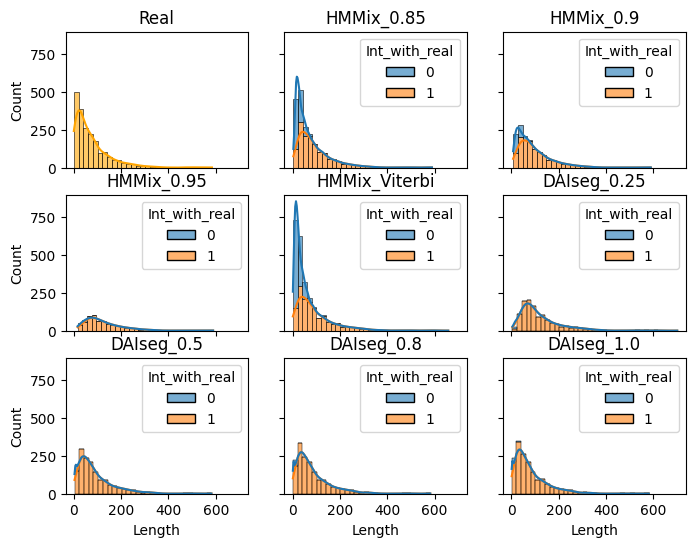

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(8, 6), sharey=True, sharex='all')
#fig.suptitle('Length distribution of tracts')
sns.histplot(ax=axes[0][0], data=df[df['Marker']=='real'], x='Length', alpha=0.6, binwidth=20 ,  kde=True, color='orange')
sns.histplot(ax=axes[0][1], data=df[df['Marker']=='hmmix_0.85'], x='Length', alpha=0.6, binwidth=20,  kde=True, hue='Int_with_real',multiple='stack', hue_order=[0,1]  )
sns.histplot(ax=axes[0][2], data=df[df['Marker']=='hmmix_0.9'], x='Length', alpha=0.6, binwidth=20,  kde=True, hue='Int_with_real',multiple='stack', hue_order=[0,1]  )
sns.histplot(ax=axes[1][0], data=df[df['Marker']=='hmmix_0.95'], x='Length', alpha=0.6, binwidth=20,  kde=True, hue='Int_with_real',multiple='stack')

sns.histplot(ax=axes[1][1], data=df[df['Marker']=='hmmix_0.999'], x='Length', alpha=0.6, binwidth=20,  kde=True, hue='Int_with_real',multiple='stack', label='lkjf')


sns.histplot(ax=axes[1][2], data=df[df['Marker']=='daiseg_0.25'], x='Length', alpha=0.6, binwidth=20,  kde=True, hue='Int_with_real',multiple='stack')
sns.histplot(ax=axes[2][0], data=df[df['Marker']=='daiseg_0.5'], x='Length', alpha=0.6, binwidth=20,  kde=True, hue='Int_with_real',multiple='stack')
sns.histplot(ax=axes[2][1], data=df[df['Marker']=='daiseg_0.8'], x='Length', alpha=0.6, binwidth=20,  kde=True, hue='Int_with_real',multiple='stack')

sns.histplot(ax=axes[2][2], data=df[df['Marker']=='daiseg_0.999'], x='Length', alpha=0.6, binwidth=20,  kde=True, hue='Int_with_real',multiple='stack')
axes[0][0].set_title('Real')
axes[0][1].set_title('HMMix_0.85')
axes[0][2].set_title('HMMix_0.9')
axes[1][0].set_title('HMMix_0.95')
axes[1][1].set_title('HMMix_Viterbi')
axes[1][2].set_title('DAIseg_0.25')
axes[2][0].set_title('DAIseg_0.5')
axes[2][1].set_title('DAIseg_0.8')
axes[2][2].set_title('DAIseg_1.0')
plt.savefig('Length.distribution.pdf', format='pdf', transparent=True)
plt.show()



# Precision/recall by length

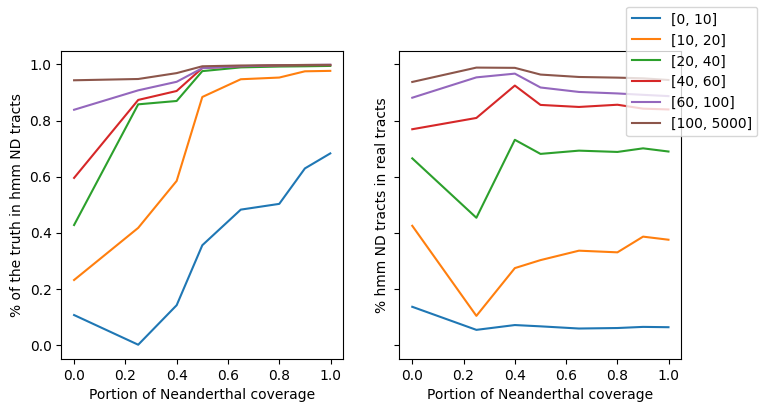

In [8]:
cover_labels=['hmmix_'+str(0.999)]+['daiseg_'+str(_) for _ in cover_mas]

precision=[]
for _ in cover_labels:

    df2=df[df['Marker']==_]   
    df2.head()
    s=[0 for j in range(len(bounds))]
    for b in range(len(labels)):        
        s[b]=(df2[df2['Length_category']==labels[b]]['%Truth'].sum())/(df2[df2['Length_category']==labels[b]]['Length'].sum()*1000)

    precision.append(s)

precision=np.array(precision)
precision= precision.transpose() 

recall=[]
df1=df[df['Marker']=='real']
df2=[df[df['Marker']==j] for j in cover_labels]
for l in labels:
    length_cover=[0 for _ in cover_labels]
    length_full=0
    lc_m2=[]
    for j in df1[df1['Length_category']==l]['POS']:     
        length_full += j[1]- j[0]
        for c in range(len(cover_labels) ):
            df22=df2[c]        
            for i in df22['POS']:
                length_cover[c]+=useful.len_tracts(useful.intersections([j], [i]))

    recall.append([length_cover[__]/length_full for __ in range(len(cover_labels))])
    
recall=np.array(recall)


fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
for s, k in zip(['pr'], [1]):
    for j, c in zip(range(len(bounds)), ['r', 'g', 'b', 'c', 'm', 'y', 'salmon']):        
        axes[0].plot([0]+[_ for _ in cover_mas], precision[j],    markersize=1, label=str(bounds[j]))
        axes[1].plot([0]+[_ for _ in cover_mas], recall[j],    markersize=1, label=str(bounds[j]))

axes[0].set_xlabel("Portion of Neanderthal coverage")
axes[1].set_xlabel("Portion of Neanderthal coverage")
axes[0].set_ylabel('% of the truth in hmm ND tracts')
axes[1].set_ylabel('% hmm ND tracts in real tracts')


l, lines=[],[]
for ax in fig.axes: 
    Line, Label = ax.get_legend_handles_labels() #

    lines.extend(Line) 
    l.extend(Label) 
    
    break    
fig.legend(lines, l, loc='upper right') 
plt.savefig('Length.quality.pdf', format='pdf', transparent=True)

plt.show()

# Deviation from total and from mean length

In [9]:
c=round(df[df['Marker']=='real']['Length'].sum(),3) 
c_mean=round(df[df['Marker']=='real']['Length'].sum()/df[df['Marker']=='real']['Length'].count(),3) 
c_20=round(df[(df['Marker']=='real') & (df['Length']>20)]['Length'].sum(),3) 
c_20_mean=round(df[(df['Marker']=='real') & (df['Length']>20)]['Length'].sum()/df[(df['Marker']=='real') & (df['Length']>20)]['Length'].count(),3) 


print('total portion of <20.000 tracts: ', (c-c_20)/c)

for cut in cut_mas:
    p=df[df['Marker']=='hmmix_'+str(cut)]['Length']
    print('Total variation from the mean '+str(cut), round(-(p.sum()-c)/c,3), 'Var of mean ', round(-(p.sum()/p.count()-c_mean)/c_mean,3))

for cover in cover_mas:
    p=df[df['Marker']=='daiseg_'+str(cover)]['Length']
    print('Total variation from mean ' + str(cover), round(-(p.sum()-c)/c,3), 'VAr of mean ', round(-(p.sum()/p.count()-c_mean)/c_mean,3))


for cut in cut_mas:
    p=df[(df['Marker']=='hmmix_'+str(cut)) & (df['Length']>20)]['Length']
    print('HMMIX '+str(cut)+': ',round((-p.sum()+c_20)/c_20,3), 'Var o mean ', round(-(p.sum()/p.count()-c_20_mean)/c_20_mean,3))

        
for cover in cover_mas:
    p=df[(df['Marker']=='daiseg_'+str(cover)) & (df['Length']>20)]['Length']
    print('DAISEG '+str(cover)+': ',round((-p.sum()+c_20)/c_20,3), 'Var o mean ', round(-(p.sum()/p.count()-c_20_mean)/c_20_mean,3))


total portion of <20.000 tracts:  0.03202685864560579
Total variation from the mean 0.85 -0.008 Var of mean  0.005
Total variation from the mean 0.9 0.127 Var of mean  -0.228
Total variation from the mean 0.95 0.459 Var of mean  -0.661
Total variation from the mean 0.999 -0.094 Var of mean  0.115
Total variation from mean 0.25 0.038 VAr of mean  -0.614
Total variation from mean 0.4 0.017 VAr of mean  -0.356
Total variation from mean 0.5 0.089 VAr of mean  -0.216
Total variation from mean 0.65 0.101 VAr of mean  -0.168
Total variation from mean 0.8 0.105 VAr of mean  -0.141
Total variation from mean 0.9 0.108 VAr of mean  -0.106
Total variation from mean 0.999 0.114 VAr of mean  -0.102
HMMIX 0.85:  -0.009 Var o mean  0.104
HMMIX 0.9:  0.11 Var o mean  -0.029
HMMIX 0.95:  0.442 Var o mean  -0.309
HMMIX 0.999:  -0.073 Var o mean  0.097
DAISEG 0.25:  0.008 Var o mean  -0.278
DAISEG 0.4:  -0.01 Var o mean  -0.105
DAISEG 0.5:  0.073 Var o mean  -0.046
DAISEG 0.65:  0.088 Var o mean  -0.017
D

# Q-q plots

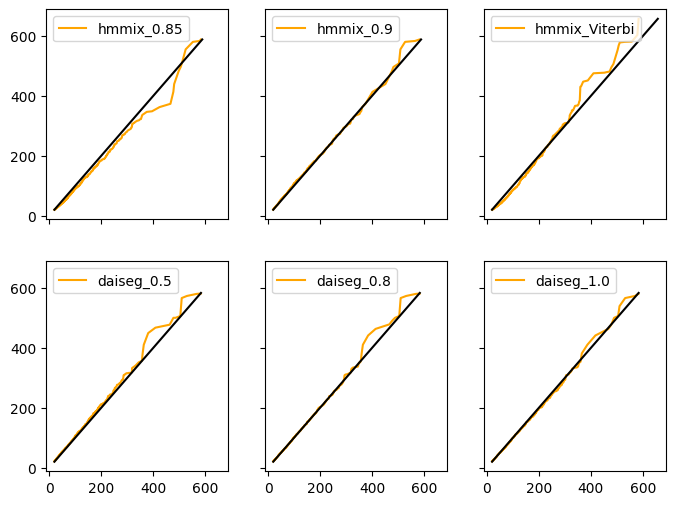

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6), sharey=True, sharex='all')
real=np.array(df[(df['Marker']=='real') & (df['Length']>20)]['Length'])



for j,ind  in zip(['hmmix_'+str(_) for _ in [0.85, 0.9, 0.999]]+['daiseg_'+str(_) for _ in [0.5, 0.8, 0.999]], [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]]):
    test=np.array(df[(df['Marker']==j) & (df['Length']>20)]['Length'])
    real.sort()
    test.sort()
    quantile_levels_real = np.arange(len(real),dtype=float)/len(real)
    quantile_levels_test = np.arange(len(test),dtype=float)/len(test)

    #Use the smaller set of quantile levels to create the plot

#We already have the set of quantiles for the smaller data set
    quantiles2 = test
#We find the set of quantiles for the larger data set using linear interpolation
    quantiles1 = np.interp(quantile_levels_test,quantile_levels_real, real)
    if j=='daiseg_'+str(0.999):        
        l='daiseg_1.0'
    elif j=='hmmix_'+str(0.999):
        l='hmmix_Viterbi'
    else:
        l=j


    axes[ind[0]][ind[1]].plot(quantiles1,quantiles2, color='orange',  label=l)
    
#Add a reference line
    maxval = max(real[-1],test[-1])
    minval = min(real[0],test[0])
    axes[ind[0]][ind[1]].plot([minval,maxval],[minval,maxval],'k-')
    axes[ind[0]][ind[1]].legend()


plt.savefig('qqplot.pdf', format='pdf', transparent=True)

# Splitting and merged tracts

In [ ]:
methods=list(set(df['Marker']))
methods.remove('real')

df_real=df[df['Marker']=='real']['POS']

x=np.array(list(range(20000,70000,500)))
y=[[] for _ in range(len(methods))]

# for splitted tracts
for dist in x:

    for label in methods:
        df_label=df[df['Marker']==label]
        pair_set=[]
        for j in range(len(df_label)-1):
            if -list(df_label['POS'])[j][1]+list(df_label['POS'])[j+1][0] < dist :
                pair_set.append([list(df_label['POS'])[j],list(df_label['POS'])[j+1]])
    
    
    
    
        pair_count=0
        r_m=[]
        for p in pair_set:
            for j in list(df_real):   
                if useful.intersections([p[0]],[j])!=[] and useful.intersections([p[1]],[j])!=[]:
                    pair_count+=1
    #                print(j, '    ', p[0], p[1], p[1][0]-p[0][1])
                    r_m.append(j)
        y[methods.index(label)].append(pair_count/len(pair_set))


df2=df[(df['Marker']=='real')]

# for real tracts
x_merged=np.array(list(range(10000,200000,10000)))
y_merged=[[] for _ in range(len(methods))]
for dist in x_merged:

    pair_set=[] # set of neghboring real tracts
    for j in range(len(df2['POS'])-1):
        if -df2['POS'][j][1]+df2['POS'][j+1][0] < dist :
            pair_set.append([df2['POS'][j],df2['POS'][j+1] ])
    
    for label in methods:
        c=0
        for ps in pair_set:
            for j in df[df['Marker']==label]['POS']:            
                if useful.intersections([ps[0]],[j])!=[] and useful.intersections([ps[1]],[j])!=[]:
                    c+=1
    
#        print('% of neighboring pairs that gluing together',l,round(c/len(pair_set),3))
        y_merged[methods.index(label)].append(c/len(pair_set))
        
    
fig, ax = plt.subplots(1,2, figsize=(8, 4))
for label in sorted(methods):
    if label not in ['daiseg_0.4', 'daiseg_0.65', 'daiseg_0.9'] :
        if label=='hmmix_0.999':
            ax[1].plot(x, y[methods.index(label)], label='hmmix_Viterbi')
            ax[0].plot(x_merged, y_merged[methods.index(label)], label='hmmix_Viterbi')
        elif  label=='daiseg_0.999':
            ax[1].plot(x, y[methods.index(label)], label='daiseg_1.0')     
            ax[0].plot(x_merged, y_merged[methods.index(label)], label='daiseg_1.0')
        else:
            ax[1].plot(x, y[methods.index(label)], label=label)
            ax[0].plot(x_merged, y_merged[methods.index(label)], label=label)            

#fig.legend(loc='right')
ax[0].set_xlabel("Distance between pairs of real tracts")
ax[1].set_xlabel("Distance between pairs of interfered tracts")
ax[1].set_ylabel("Portion of splitted tracts")
ax[0].set_ylabel("Portion of glued pairs")

l, lines=[],[]
for ax in fig.axes: 
    Line, Label = ax.get_legend_handles_labels() #

    lines.extend(Line) 
    l.extend(Label) 
    
    break    
fig.legend(lines, l, loc='upper right') 
plt.savefig('Splitted_tracts.pdf', format='pdf', transparent=True)
plt.show() 

# EM

In [ ]:
#read daiseg
tracts_daiseg_mas=[]
df_daiseg_mas=[]

for cover in cover_mas:
    daiseg=[]
    for _ in range(number_chr):
        daiseg.append(useful.read_out(dir+'out.chr'+str(_+1)+'.cover.'+str(cover)+'.archaic.txt')[0])
    tracts_daiseg = many_in_one(daiseg, number_chr, length)
    tracts_daiseg_mas.append(tracts_daiseg)

    df_daiseg_mas.append(sims.df_result_lonf_chr(real_tracts_in_states, tracts_daiseg, N_neanderthal,  N_ref_pop, 2))


#read daiseg
tracts_daiseg_mas_EM=[]
df_daiseg_mas_EM=[]

for cover in cover_mas:
    daiseg=[]
    for _ in range(number_chr):
        daiseg.append(useful.read_out(dir+'out.chr'+str(_+1)+'.cover.'+str(cover)+'.EM.archaic.txt')[0])
    tracts_daiseg = many_in_one(daiseg, number_chr, length)
    tracts_daiseg_mas_EM.append(tracts_daiseg)

    df_daiseg_mas_EM.append(sims.df_result_lonf_chr(real_tracts_in_states, tracts_daiseg, N_neanderthal,  N_ref_pop, 2))

#create dataframe with results

df=pd.DataFrame(columns=['CHR', 'POS','Marker', 'Length', 'Int_with_real', 'Int_count', '%Truth', 'Length_category'])
tracts=[real_tracts_in_states[1]]+[tracts_daiseg_mas[_][1] for _ in range(len(cover_mas))]+[tracts_daiseg_mas_EM[_][1] for _ in range(len(cover_mas))]
markers=['real']+ ['daiseg_'+str(cover) for cover in cover_mas]+['daiseg_EM_'+str(cover) for cover in cover_mas]

for _, m in zip(tracts, markers):  
    for j in _:
        #counting number of intersections        
        k=0
        for i in tracts[0]:
            if useful.intersections([j], [i]):
                k+=1
        for b in bounds:            
            if (j[1]-j[0]+1)/1000>=b[0] and (j[1]-j[0]+1)/1000<=b[1]:
                length_cat=labels[bounds.index(b)]                
        if k==0:
            df.loc[len(df)]=[int(j[1]//length)+1,j,m, (j[1]-j[0]+1)/1000, 0, k, 0, length_cat]
        else:            
            df.loc[len(df)]=[int(j[1]//length)+1,j,m, (j[1]-j[0]+1)/1000, 1, k, 
                             useful.len_tracts(useful.intersections([j], tracts[0])), length_cat]

In [ ]:
l=list(df[df['Marker']=='daiseg_0.8']['POS'])
l_EM=list(df[df['Marker']=='daiseg_EM_0.8']['POS'])



common=[x for x in l_EM if x in l]
l_EM_no_l = [x for x in l_EM if x not in l] 
l_no_l_EM = [x for x in l if x not in l_EM] 

In [ ]:
tr_yes, tr_no = [], []
for j in l: 

    if useful.intersections([j],real_tracts_in_states[1])!=[]:            
        tr_yes.append(j)
    if useful.intersections([j],real_tracts_in_states[1])==[] :            
        tr_no.append(j)

print(len(tr_yes),len(tr_no))

freq_mas=[0 for j in range(len(bounds))]

for j in tr_yes:
    for b in range(len(bounds)):  
        if (j[1]-j[0]+1)/1000>=bounds[b][0] and (j[1]-j[0]+1)/1000<=bounds[b][1]:
            freq_mas[b]=freq_mas[b]+1
    
print('For truth : ',freq_mas)

freq_mas=[0 for j in range(len(bounds))]

for j in tr_no:
    for b in range(len(bounds)):  
        if (j[1]-j[0]+1)/1000>=bounds[b][0] and (j[1]-j[0]+1)/1000<=bounds[b][1]:
            freq_mas[b]=freq_mas[b]+1
    
print('For lie : ',freq_mas)


basic=[]
for j in tr_yes:
    if j[1]-j[0]>10000:
        basic.append(j)
        

In [ ]:
tr_yes, tr_no = [], []
for j in l_EM: 

    if useful.intersections([j],real_tracts_in_states[1])!=[]:            
        tr_yes.append(j)
    if useful.intersections([j],real_tracts_in_states[1])==[] :            
        tr_no.append(j)

print(len(tr_yes),len(tr_no))

freq_mas=[0 for j in range(len(bounds))]

for j in tr_yes:
    for b in range(len(bounds)):  
        if (j[1]-j[0]+1)/1000>=bounds[b][0] and (j[1]-j[0]+1)/1000<=bounds[b][1]:
            freq_mas[b]=freq_mas[b]+1
    
print('For truth : ',freq_mas)

freq_mas=[0 for j in range(len(bounds))]

for j in tr_no:
    for b in range(len(bounds)):  
        if (j[1]-j[0]+1)/1000>=bounds[b][0] and (j[1]-j[0]+1)/1000<=bounds[b][1]:
            freq_mas[b]=freq_mas[b]+1
    
print('For lie : ',freq_mas)


In [ ]:
#tracts that are in EM but do no intersect with noEM

tr_yes, tr_no = [], []
for j in l_EM_no_l: #in DAIseg no in DAIseg.EM

    if useful.intersections([j],real_tracts_in_states[1])!=[] and useful.intersections([j], l)==[] and j[1]-j[0]>15000:            
        tr_yes.append(j)
    if useful.intersections([j],real_tracts_in_states[1])==[] and useful.intersections([j], l)==[]:            
        tr_no.append(j)
freq_mas=[0 for j in range(len(bounds))]
for j in tr_yes:
    for b in range(len(bounds)):  
        if (j[1]-j[0]+1)/1000>=bounds[b][0] and (j[1]-j[0]+1)/1000<=bounds[b][1]:
            freq_mas[b]=freq_mas[b]+1
    
print('For truth : ',freq_mas)

freq_mas=[0 for j in range(len(bounds))]

for j in tr_no:
    for b in range(len(bounds)):  
        if (j[1]-j[0]+1)/1000>=bounds[b][0] and (j[1]-j[0]+1)/1000<=bounds[b][1]:
            freq_mas[b]=freq_mas[b]+1
    
print('For lie : ',freq_mas)

extra_tracts=tr_yes


# Work with real data

In [ ]:
sample_list=[_ for _ in range(0, 100)]
df=pd.DataFrame(columns=['CHR', 'POS','Sample', 'Length'])
for sample in sample_list:


    for CHR in range(1, 23):
        with open('./daiseg.IBS/out.IBS.EM.chr'+str(CHR)+'.archaic.txt','r') as f:
            l=f.readlines()
        l=l[sample].replace('[[','').replace(']]','').strip().split('\t')[2]
        
        l=l.split('], [')
        l=[[int(l[j].split(', ')[0]), int(l[j].split(', ')[1])] for j in range(len(l))]
    
        for _ in l:
            df.loc[len(df)]=[CHR, _, sample, _[1]-_[0]]


fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey=True, sharex='all')
#fig.suptitle('Length distribution of tracts')
sns.histplot(ax=axes[0], data=df[df['Sample']==0], x='Length', alpha=0.6, binwidth=20000 ,  kde=True, color='orange')
sns.histplot(ax=axes[1], data=df[df['Sample']==1], x='Length', alpha=0.6, binwidth=20000 ,  kde=True, color='orange')


for j in sample_list:
    print(df[df['Sample']==j]['Length'].sum()/df[df['Sample']==j]['Length'].count())


# Skipping short tracts (need to check)

In [ ]:
reload(useful)
reload(sims)
#read daiseg
tracts_daiseg_mas=[]
df_daiseg_mas_short=[]
cover_mas=[0.25, 0.4, 0.5, 0.65, 0.8, 0.9, 0.999]

for cover in cover_mas:
    daiseg=[]
    for _ in range(number_chr):
        daiseg.append(useful.read_out_short(dir+'out.chr'+str(_+1)+'.cover.'+str(cover)+'.EM.archaic.txt')[0])
    tracts_daiseg = many_in_one(daiseg, number_chr, length)
    tracts_daiseg_mas.append(tracts_daiseg)

    df_daiseg_mas_short.append(sims.df_result_lonf_chr(real_tracts_in_states, tracts_daiseg, N_neanderthal,  N_ref_pop, 2))


#read hmmix tracts
cut_mas=[0.85, 0.9, 0.95, 0.999]
df_hmmix_short=[]
for cut in cut_mas:

    hmmmix_tr=[[] for j in range(number_chr)]
    for j in range(1, number_chr+1):
        if cut!=0.999:
            file=dir+'out.chr'+str(j)+'.no.init.hap1.txt'    
        else:
            file=dir+'out.chr'+str(j)+'.viterbi.hap1.txt'   #for Viterbi
        hmmmix_tr[j-1]=sims.read_noND2_short(file, cut )


        
    hmmix=many_in_one(hmmmix_tr,number_chr, length)
    hmmix_mas.append(hmmix)
    df_hmmix_short.append(sims.df_result_lonf_chr(real_tracts_in_states, hmmix, N_neanderthal,  N_ref_pop, 2))

# Deviation from mean tract length by chr (something strange)

In [ ]:
#deviation of mean by chr

x=[_ for _ in range(1,number_chr+1)]
means={}
for m in list(set(df['Marker'])):
    d=df[df['Marker']==m][['CHR','Length']]    
    means[m]=np.array(d.groupby(['CHR']).mean()['Length'])

fig, ax = plt.subplots( figsize=(5, 5))

ax.plot(x, sorted([(x-y)/y for x,y in zip(means['daiseg_0.999'],means['real'])]), label='daiseg_1.0')
ax.plot(x, sorted([(x-y)/y for x,y in zip(means['hmmix_0.9'],means['real'])]), label='hmmix_0.9')
ax.plot(x, sorted([(x-y)/y for x,y in zip(means['daiseg_0.5'],means['real'])]), label='daiseg_0.5')
ax.plot(x, sorted([(x-y)/y for x,y in zip(means['daiseg_0.8'],means['real'])]), label='daiseg_0.8')
#plt.plot(x, [(x-y)/y for x,y in zip(df_means['daiseg'],df_means['real'])], label='daiseg')


ax.set_ylabel('Deviation from the real mean length divided by the real mean')
ax.set_xlabel(' CHR')
plt.legend()

#plt.savefig('deviation.of.mean.eps', format='eps', transparent=True)

#plt.show()
